### Bouding Box Annotations

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to your folders
dataset_path = "/Volumes/Exodus/Data/ART-Net/"

train_positive_images_path = os.path.join(dataset_path, "Train/Train_Positive")
train_negative_images_path = os.path.join(dataset_path, "Train/Train_Negative")
train_masks_path = os.path.join(dataset_path, "Train/Train_Positive_Tool_Mask")
train_labels_path = os.path.join(dataset_path, "labels/train")

test_positive_images_path = os.path.join(dataset_path, "Test/Test_Positive")
test_negative_images_path = os.path.join(dataset_path, "Test/Test_Negative")
test_masks_path = os.path.join(dataset_path, "Test/Test_Positive_Tool_Mask")
test_labels_path = os.path.join(dataset_path, "labels/val")

os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Function to create YOLO annotations from masks
def create_annotations(images_path, masks_path, labels_path, n = None):
    if n is not None:
        image_files = sorted([f for f in os.listdir(images_path) if f.endswith(".png") and not f.startswith("._")])[:n]
    else:
        image_files = sorted([f for f in os.listdir(images_path) if f.endswith(".png") and not f.startswith("._")])

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        mask_file = image_file.replace(".png", "_Tool_Mask.png")
        mask_path = os.path.join(masks_path, mask_file)

        # print(image_path)
        # print(mask_path)

        if os.path.exists(mask_path):
            # print(f"Processing {image_file}...")
            # Load the mask image
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Open the corresponding label file
            label_file = os.path.join(labels_path, image_file.replace(".png", ".txt"))
            with open(label_file, "w") as lf:
                for contour in contours:
                    x, y, w, h = cv2.boundingRect(contour)
                    # Normalize coordinates
                    x_center = (x + w / 2) / mask.shape[1]
                    y_center = (y + h / 2) / mask.shape[0]
                    width = w / mask.shape[1]
                    height = h / mask.shape[0]
                    # Write to label file in YOLO format
                    lf.write(f"0 {x_center} {y_center} {width} {height}\n")

                # # use matplotlib to display the images with bounding box
                # image = cv2.imread(image_path)
                # for contour in contours:
                #     x, y, w, h = cv2.boundingRect(contour)
                #     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                # plt.axis("off")
                # plt.show()

    print("Annotations created in YOLO format.")

# Create annotations for training images
create_annotations(train_positive_images_path, train_masks_path, train_labels_path)
# Create annotations for test images
create_annotations(test_positive_images_path, test_masks_path, test_labels_path)

### Process ART-Net Data in YOLO Format

In [ ]:
from calendar import c
import os
import cv2
import numpy as np

# Define the paths
base_path = "data 2/ART-Net/"
train_positive_images_path = os.path.join(base_path, "Train/Train_Positive")
test_positive_images_path = os.path.join(base_path, "Test/Test_Positive")
train_negative_images_path = os.path.join(base_path, "Train/Train_Negative")
test_negative_images_path = os.path.join(base_path, "Test/Test_Negative")

train_mask_path = os.path.join(base_path, "Train/Train_Positive_Tool_Mask")
test_mask_path = os.path.join(base_path, "Test/Test_Positive_Tool_Mask")
train_tip_mask_path = os.path.join(base_path, "Train/Train_Positive_TipPoint")
test_tip_mask_path = os.path.join(base_path, "Test/Test_Positive_TipPoint")

train_label_path = os.path.join(base_path, "labels/train")
test_label_path = os.path.join(base_path, "labels/val")
train_image_dest = os.path.join(base_path, "images/train")
test_image_dest = os.path.join(base_path, "images/val")

# Make sure label and image directories exist
os.makedirs(train_label_path, exist_ok=True)
os.makedirs(test_label_path, exist_ok=True)
os.makedirs(train_image_dest, exist_ok=True)
os.makedirs(test_image_dest, exist_ok=True)


def create_bounding_box(mask):
    # Get the indices of non-black pixels
    non_zero_indices = np.nonzero(mask)
    if len(non_zero_indices[0]) == 0:
        return None
    x_min = np.min(non_zero_indices[1])
    y_min = np.min(non_zero_indices[0])
    x_max = np.max(non_zero_indices[1])
    y_max = np.max(non_zero_indices[0])
    return x_min, y_min, x_max - x_min, y_max - y_min


def create_yolo_label(mask_path, label_file, class_id, img_w, img_h):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return
    # Resize the mask to match the image size
    mask = cv2.resize(mask, (img_w, img_h))
    bbox = create_bounding_box(mask)
    if bbox is None:
        return
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    width = w / img_w
    height = h / img_h
    # # Plot the bounding box on image
    # cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)

    # cv2.destroyAllWindows()

    with open(label_file, "a") as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # # Validate by plotting the bounding box on the image
    # with open(label_file, "r") as f:
    #     lines = f.readlines()
    #     if class_id == 0:
    #         image_path = mask_path.replace("_Tool_Mask", "")
    #     else:
    #         image_path = mask_path.replace("_TipPoint", "")
    #     image_path = os.path.join("data 2/ART-Net/images/train", os.path.basename(image_path))
    #     image = cv2.imread(image_path)
    #     img_h, img_w = image.shape[:2]
    #     for line in lines:
    #         class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #         x = int((x_center - width / 2) * img_w)
    #         y = int((y_center - height / 2) * img_h)
    #         w = int(width * img_w)
    #         h = int(height * img_h)
    #         cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    #     cv2.imshow("image", image)
    #     cv2.waitKey(0)

    # cv2.destroyAllWindows()


def process_positive_images(image_dir, mask_dir, tip_mask_dir, label_dir, image_dest):
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            print(image_file)
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, image_file).replace(
                ".png", "_Tool_Mask.png"
            )
            tip_mask_path = os.path.join(tip_mask_dir, image_file).replace(
                ".png", "_TipPoint.png"
            )
            label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
            dest_image_path = os.path.join(image_dest, image_file)

            # Read the image to get its size
            image = cv2.imread(image_path)
            img_h, img_w = image.shape[:2]

            # Copy the image file to the destination
            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)
            cv2.imwrite(dest_image_path, cv2.imread(image_path))

            # Delete label file if it exists
            if os.path.exists(label_file):
                os.remove(label_file)

            # Create label for tool
            create_yolo_label(
                mask_path, label_file, class_id=0, img_w=img_w, img_h=img_h
            )

            # Create label for tool tip
            create_yolo_label(
                tip_mask_path, label_file, class_id=1, img_w=img_w, img_h=img_h
            )


def process_negative_images(image_dir, label_dir, image_dest):
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            image_path = os.path.join(image_dir, image_file)
            label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
            dest_image_path = os.path.join(image_dest, image_file)

            # Copy the image file to the destination
            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)
            cv2.imwrite(dest_image_path, cv2.imread(image_path))

            # Create an empty label file
            open(label_file, "w").close()


# Process all datasets
process_positive_images(
    train_positive_images_path,
    train_mask_path,
    train_tip_mask_path,
    train_label_path,
    train_image_dest,
)
process_positive_images(
    test_positive_images_path,
    test_mask_path,
    test_tip_mask_path,
    test_label_path,
    test_image_dest,
)
# process_negative_images(train_negative_images_path, train_label_path, train_image_dest)
# process_negative_images(test_negative_images_path, test_label_path, test_image_dest)

print("Processing complete.")


# Iterate over images and plot bounding boxes
def view_bounding_boxes():
    for image_file in os.listdir(train_image_dest):
        if image_file.endswith(".png") and image_file.startswith("Train_Pos"):
            image_path = os.path.join(train_image_dest, image_file)
            label_file = os.path.join(
                train_label_path, image_file.replace(".png", ".txt")
            )
            image = cv2.imread(image_path)
            img_h, img_w = image.shape[:2]
            with open(label_file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id, x_center, y_center, width, height = map(
                        float, line.strip().split()
                    )
                    x = int((x_center - width / 2) * img_w)
                    y = int((y_center - height / 2) * img_h)
                    w = int(width * img_w)
                    h = int(height * img_h)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.imshow("image", image)
            cv2.waitKey(0)

### Create validation split equal to test split

In [ ]:
# Check how many images in data/ART-Net/images/test
import os
import cv2

path = "data 2/ART-Net/images/test"
files = os.listdir(path)
count = 0
for file in files:
    if file.endswith(".png") and "Pos" not in file:
        count += 1
print(count)

# 308 test images 154 pos and 154 neg
# 1324 train images 662 pos and 662 neg

# Define the paths
base_path = "data 2/ART-Net/"
train_positive_images_path = os.path.join(base_path, "Train/Train_Positive")
test_positive_images_path = os.path.join(base_path, "Test/Test_Positive")
train_negative_images_path = os.path.join(base_path, "Train/Train_Negative")
test_negative_images_path = os.path.join(base_path, "Test/Test_Negative")

train_label_path = os.path.join(base_path, "labels/train")
test_label_path = os.path.join(base_path, "labels/test")
train_image_dest = os.path.join(base_path, "images/train")
test_image_dest = os.path.join(base_path, "images/test")

val_image_dest = os.path.join(base_path, "images/val")
val_label_dest = os.path.join(base_path, "labels/val")

# Select 154 pos and 154 neg from train images at random to add to val images and labels folder
import random

random.seed(42)

train_pos_files = os.listdir(train_positive_images_path)
train_neg_files = os.listdir(train_negative_images_path)
train_pos_files = random.sample(train_pos_files, 154)
train_neg_files = random.sample(train_neg_files, 154)

# Move the selected images to val images folder (and corresponding label file)
import shutil

for file in train_pos_files:
    print(file)
    shutil.move(
        os.path.join(train_positive_images_path, file),
        os.path.join(val_image_dest, file),
    )
    label_file = file.replace(".png", ".txt")
    shutil.move(
        os.path.join(train_label_path, label_file),
        os.path.join(val_label_dest, label_file),
    )


for file in train_neg_files:
    print(file)
    shutil.move(
        os.path.join(train_negative_images_path, file),
        os.path.join(val_image_dest, file),
    )
    label_file = file.replace(".png", ".txt")
    shutil.move(
        os.path.join(train_label_path, label_file),
        os.path.join(val_label_dest, label_file),
    )

### Segmentation YOLO label files

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Paths to your folders
dataset_path = "/Volumes/Exodus/Data/ART-Net/"

train_positive_images_path = os.path.join(dataset_path, "Train/Train_Positive")
train_negative_images_path = os.path.join(dataset_path, "Train/Train_Negative")
train_masks_path = os.path.join(dataset_path, "Train/Train_Positive_Tool_Mask")
# train_tooltip_masks_path = os.path.join(dataset_path, "Train/Train_Positive_TipPoint")
train_labels_path = os.path.join(dataset_path, "labels/train")

test_positive_images_path = os.path.join(dataset_path, "Test/Test_Positive")
test_negative_images_path = os.path.join(dataset_path, "Test/Test_Negative")
test_masks_path = os.path.join(dataset_path, "Test/Test_Positive_Tool_Mask")
# test_tooltip_masks_path = os.path.join(dataset_path, "Test/Test_Positive_TipPoint")
test_labels_path = os.path.join(dataset_path, "labels/val")

os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)


# Function to create YOLO annotations from masks
def create_annotations(
    images_path, masks_path, tooltip_masks_path, labels_path, n=None
):
    if n is not None:
        image_files = sorted(
            [
                f
                for f in os.listdir(images_path)
                if f.endswith(".png") and not f.startswith("._")
            ]
        )[:n]
    else:
        image_files = sorted(
            [
                f
                for f in os.listdir(images_path)
                if f.endswith(".png") and not f.startswith("._")
            ]
        )

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        mask_file = image_file.replace(".png", "_Tool_Mask.png")
        mask_path = os.path.join(masks_path, mask_file)
        # tooltip_mask_file = image_file.replace(".png", "_TipPoint.png")
        # tooltip_mask_path = os.path.join(tooltip_masks_path, tooltip_mask_file)

        label_file = os.path.join(labels_path, image_file.replace(".png", ".txt"))

        with open(label_file, "w") as lf:
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                contours, _ = cv2.findContours(
                    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                )
                for contour in contours:
                    contour = contour.squeeze()  # Remove extra dimension
                    if len(contour.shape) == 1:  # Single point, duplicate to make a box
                        contour = np.array([contour, contour])
                    contour = contour.reshape(-1)
                    normalized_contour = []
                    for i in range(0, len(contour), 2):
                        x = contour[i] / mask.shape[1]
                        y = contour[i + 1] / mask.shape[0]
                        normalized_contour.extend([x, y])
                    lf.write(f"0 {' '.join(map(str, normalized_contour))}\n")

            # if os.path.exists(tooltip_mask_path):
            #     tooltip_mask = cv2.imread(tooltip_mask_path, cv2.IMREAD_GRAYSCALE)
            #     tooltip_contours, _ = cv2.findContours(
            #         tooltip_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            #     )
            #     for contour in tooltip_contours:
            #         contour = contour.squeeze()  # Remove extra dimension
            #         if len(contour.shape) == 1:  # Single point, duplicate to make a box
            #             contour = np.array([contour, contour])
            #         contour = contour.reshape(-1)
            #         normalized_contour = []
            #         for i in range(0, len(contour), 2):
            #             x = contour[i] / tooltip_mask.shape[1]
            #             y = contour[i + 1] / tooltip_mask.shape[0]
            #             normalized_contour.extend([x, y])
            #         lf.write(f"1 {' '.join(map(str, normalized_contour))}\n")
    
            # Use matplotlib to draw the images with bounding box
            image = cv2.imread(image_path)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
            # for contour in tooltip_contours:
            #     x, y, w, h = cv2.boundingRect(contour)
            #     cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")

    print("Annotations created in YOLO format.")
            #         contour = contour.reshape(-1)
            #         normalized_contour = []
            #         for i in range(0, len(contour), 2):
            #             x = contour[i] / tooltip_mask.shape[1]
            #             y = contour[i + 1] / tooltip_mask.shape[0]
            #             normalized_contour.extend([x, y])
            #         lf.write(f"1 {' '.join(map(str, normalized_contour))}\n")
    
            # Use matplotlib to draw the images with bounding box
            image = cv2.imread(image_path)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
            # for contour in tooltip_contours:
            #     x, y, w, h = cv2.boundingRect(contour)
            #     cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")

    print("Annotations created in YOLO format.")
            #         contour = contour.reshape(-1)
            #         normalized_contour = []
            #         for i in range(0, len(contour), 2):
            #             x = contour[i] / tooltip_mask.shape[1]
            #             y = contour[i + 1] / tooltip_mask.shape[0]
            #             normalized_contour.extend([x, y])
            #         lf.write(f"1 {' '.join(map(str, normalized_contour))}\n")
    
            # Use matplotlib to draw the images with bounding box
            image = cv2.imread(image_path)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
            # for contour in tooltip_contours:
            #     x, y, w, h = cv2.boundingRect(contour)
            #     cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")

    print("Annotations created in YOLO format.")
            #         contour = contour.reshape(-1)
            #         normalized_contour = []
            #         for i in range(0, len(contour), 2):
            #             x = contour[i] / tooltip_mask.shape[1]
            #             y = contour[i + 1] / tooltip_mask.shape[0]
            #             normalized_contour.extend([x, y])
            #         lf.write(f"1 {' '.join(map(str, normalized_contour))}\n")
    
            # Use matplotlib to draw the images with bounding box
            image = cv2.imread(image_path)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
            # for contour in tooltip_contours:
            #     x, y, w, h = cv2.boundingRect(contour)
            #     cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis("off")

    print("Annotations created in YOLO format.")


# Create annotations for training images
# create_annotations(
#     train_positive_images_path,
#     train_masks_path,
#     train_tooltip_masks_path,
#     train_labels_path,
# )

# # Create annotations for test images
# create_annotations(
#     test_positive_images_path,
#     test_masks_path,
#     test_tooltip_masks_path,
#     test_labels_path,
# )

### Old Running Stats

```bat
50 epochs completed in 4.264 hours.

105 epochs completed in 7.044 hours.

YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients, 343.7 GFLOPs
val: Scanning D:\Data\ART-Net\labels\test.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]
                   all        154        768       0.99      0.201      0.316      0.286       0.99      0.201      0.318      0.274
Speed: 0.3ms preprocess, 34.8ms inference, 0.0ms loss, 2.0ms postprocess per image
```

```json
test_results = {
    "metrics/precision(B)": 0.9903675376519159,
    "metrics/recall(B)": 0.20052083333333334,
    "metrics/mAP50(B)": 0.31616375813616715,
    "metrics/mAP50-95(B)": 0.2863567120717536,
    "metrics/precision(M)": 0.9903675376519159,
    "metrics/recall(M)": 0.20052083333333334,
    "metrics/mAP50(M)": 0.3179526866586455,
    "metrics/mAP50-95(M)": 0.27379489430835563,
    "fitness": 0.5675480902215796,
}
```

### Process ART-Net Data in YOLO Format

In [ ]:
from calendar import c
import os
import cv2
import numpy as np

# Define the paths
base_path = "data 2/ART-Net/"
train_positive_images_path = os.path.join(base_path, "Train/Train_Positive")
test_positive_images_path = os.path.join(base_path, "Test/Test_Positive")
train_negative_images_path = os.path.join(base_path, "Train/Train_Negative")
test_negative_images_path = os.path.join(base_path, "Test/Test_Negative")

train_mask_path = os.path.join(base_path, "Train/Train_Positive_Tool_Mask")
test_mask_path = os.path.join(base_path, "Test/Test_Positive_Tool_Mask")
train_tip_mask_path = os.path.join(base_path, "Train/Train_Positive_TipPoint")
test_tip_mask_path = os.path.join(base_path, "Test/Test_Positive_TipPoint")

train_label_path = os.path.join(base_path, "labels/train")
test_label_path = os.path.join(base_path, "labels/val")
train_image_dest = os.path.join(base_path, "images/train")
test_image_dest = os.path.join(base_path, "images/val")

# Make sure label and image directories exist
os.makedirs(train_label_path, exist_ok=True)
os.makedirs(test_label_path, exist_ok=True)
os.makedirs(train_image_dest, exist_ok=True)
os.makedirs(test_image_dest, exist_ok=True)


def create_bounding_box(mask):
    # Get the indices of non-black pixels
    non_zero_indices = np.nonzero(mask)
    if len(non_zero_indices[0]) == 0:
        return None
    x_min = np.min(non_zero_indices[1])
    y_min = np.min(non_zero_indices[0])
    x_max = np.max(non_zero_indices[1])
    y_max = np.max(non_zero_indices[0])
    return x_min, y_min, x_max - x_min, y_max - y_min


def create_yolo_label(mask_path, label_file, class_id, img_w, img_h):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return
    # Resize the mask to match the image size
    mask = cv2.resize(mask, (img_w, img_h))
    bbox = create_bounding_box(mask)
    if bbox is None:
        return
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    width = w / img_w
    height = h / img_h
    # # Plot the bounding box on image
    # cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)

    # cv2.destroyAllWindows()

    with open(label_file, "a") as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # # Validate by plotting the bounding box on the image
    # with open(label_file, "r") as f:
    #     lines = f.readlines()
    #     if class_id == 0:
    #         image_path = mask_path.replace("_Tool_Mask", "")
    #     else:
    #         image_path = mask_path.replace("_TipPoint", "")
    #     image_path = os.path.join("data 2/ART-Net/images/train", os.path.basename(image_path))
    #     image = cv2.imread(image_path)
    #     img_h, img_w = image.shape[:2]
    #     for line in lines:
    #         class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #         x = int((x_center - width / 2) * img_w)
    #         y = int((y_center - height / 2) * img_h)
    #         w = int(width * img_w)
    #         h = int(height * img_h)
    #         cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    #     cv2.imshow("image", image)
    #     cv2.waitKey(0)

    # cv2.destroyAllWindows()


def process_positive_images(image_dir, mask_dir, tip_mask_dir, label_dir, image_dest):
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            print(image_file)
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, image_file).replace(
                ".png", "_Tool_Mask.png"
            )
            tip_mask_path = os.path.join(tip_mask_dir, image_file).replace(
                ".png", "_TipPoint.png"
            )
            label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
            dest_image_path = os.path.join(image_dest, image_file)

            # Read the image to get its size
            image = cv2.imread(image_path)
            img_h, img_w = image.shape[:2]

            # Copy the image file to the destination
            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)
            cv2.imwrite(dest_image_path, cv2.imread(image_path))

            # Delete label file if it exists
            if os.path.exists(label_file):
                os.remove(label_file)

            # Create label for tool
            create_yolo_label(
                mask_path, label_file, class_id=0, img_w=img_w, img_h=img_h
            )

            # Create label for tool tip
            create_yolo_label(
                tip_mask_path, label_file, class_id=1, img_w=img_w, img_h=img_h
            )


def process_negative_images(image_dir, label_dir, image_dest):
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            image_path = os.path.join(image_dir, image_file)
            label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
            dest_image_path = os.path.join(image_dest, image_file)

            # Copy the image file to the destination
            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)
            cv2.imwrite(dest_image_path, cv2.imread(image_path))

            # Create an empty label file
            open(label_file, "w").close()


# Process all datasets
process_positive_images(
    train_positive_images_path,
    train_mask_path,
    train_tip_mask_path,
    train_label_path,
    train_image_dest,
)
process_positive_images(
    test_positive_images_path,
    test_mask_path,
    test_tip_mask_path,
    test_label_path,
    test_image_dest,
)
# process_negative_images(train_negative_images_path, train_label_path, train_image_dest)
# process_negative_images(test_negative_images_path, test_label_path, test_image_dest)

print("Processing complete.")

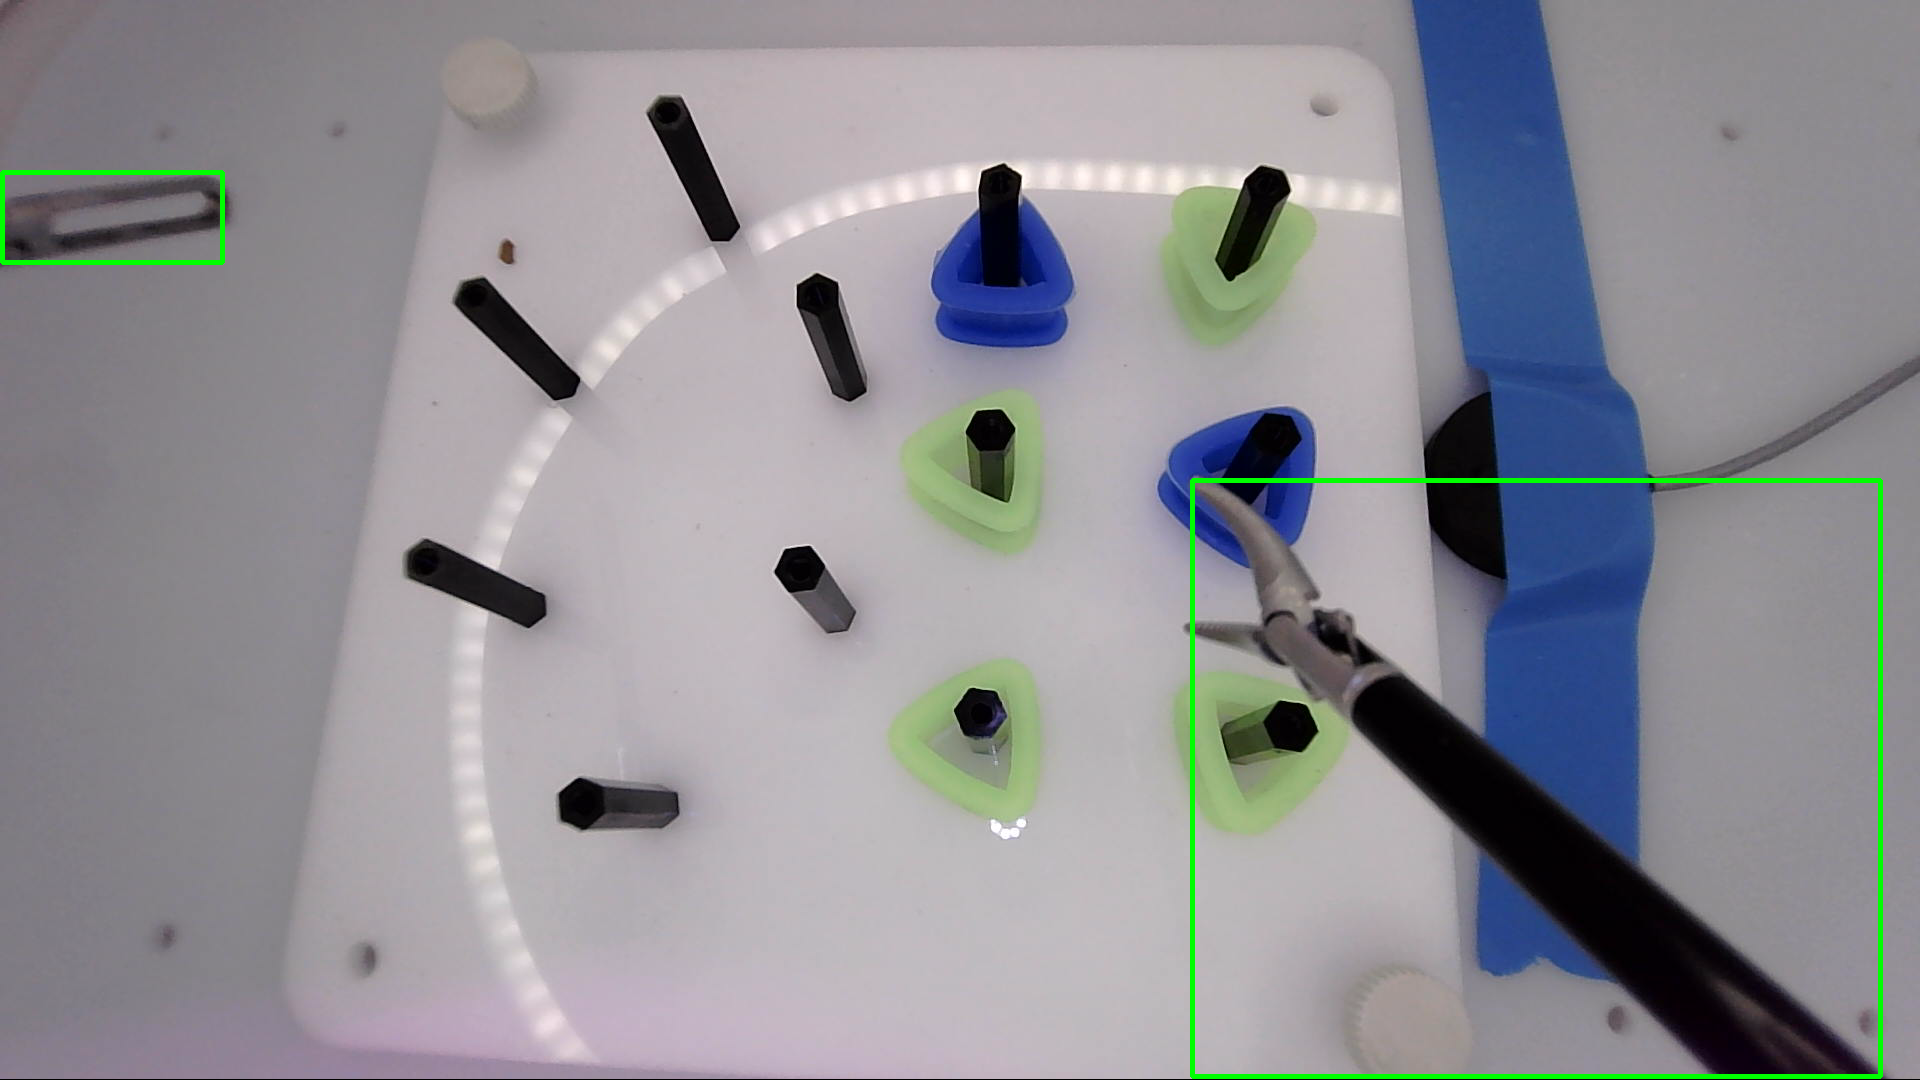

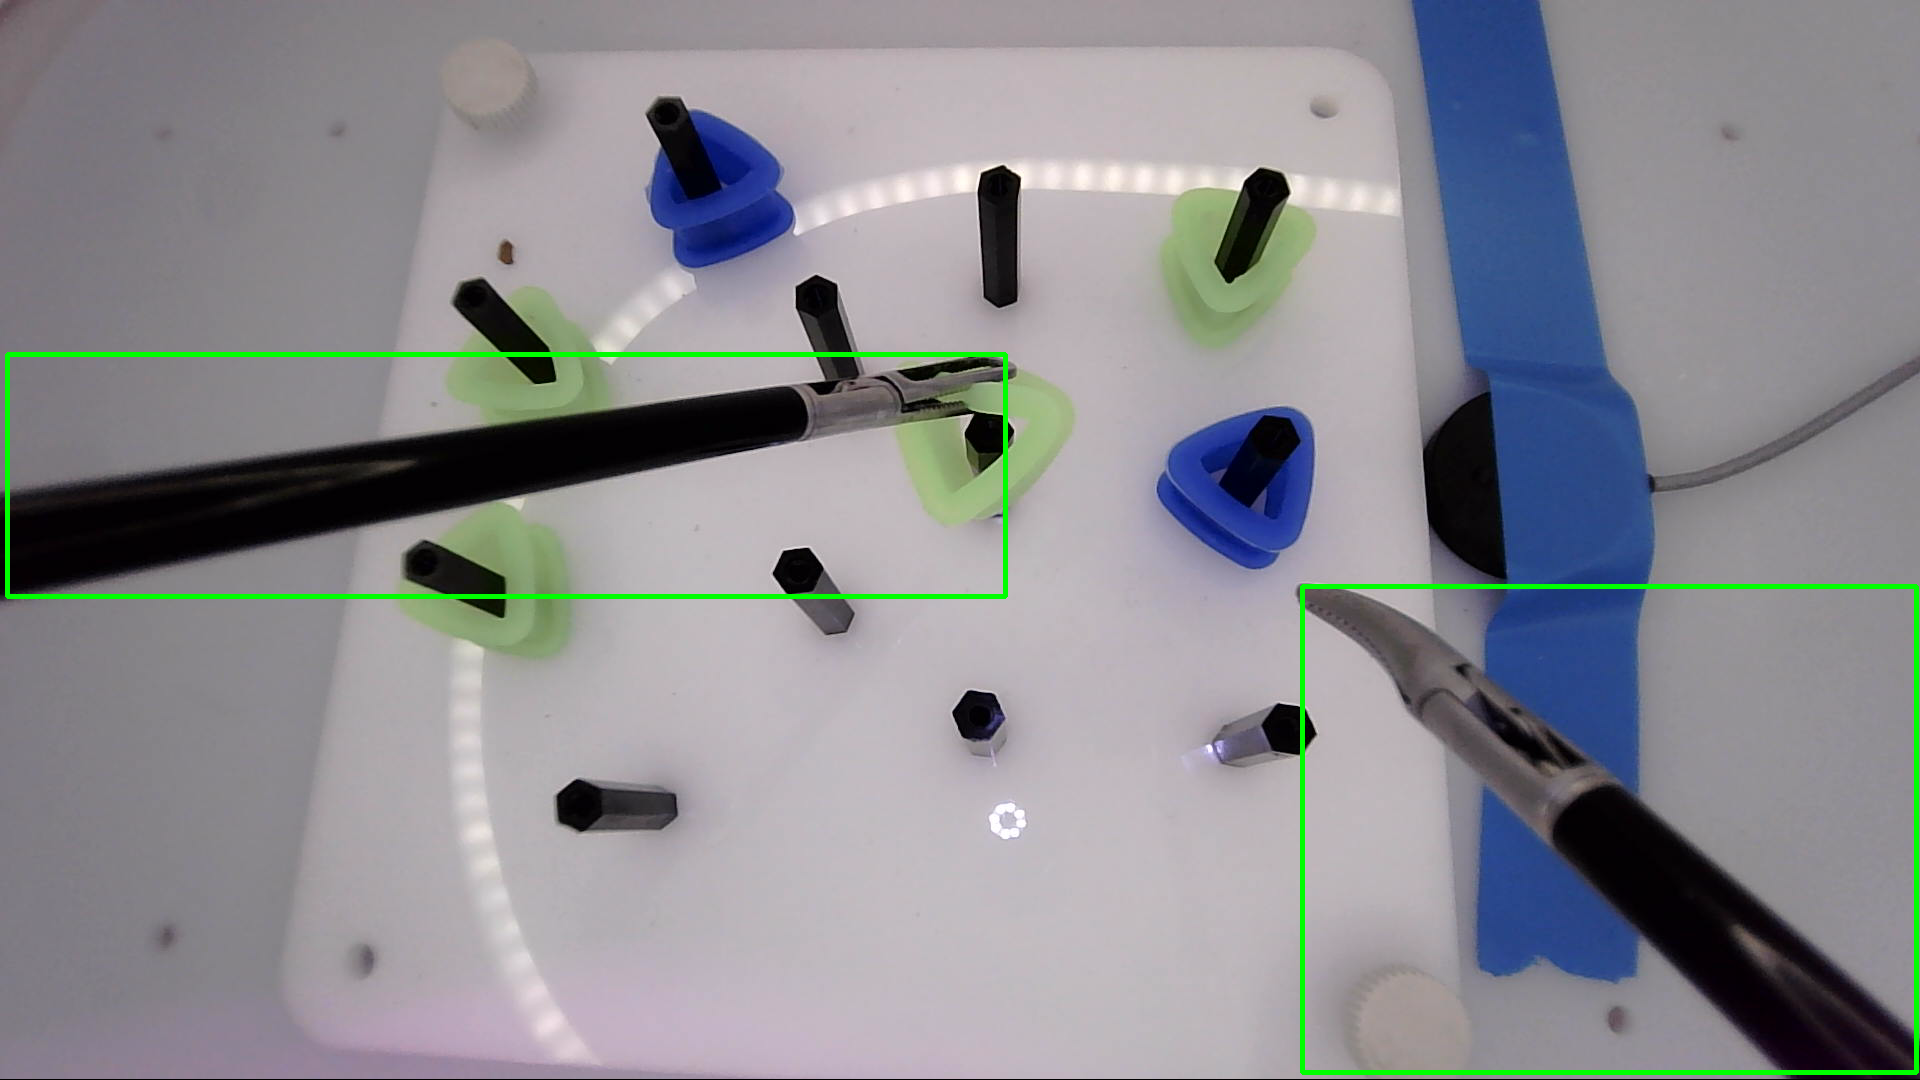

: 

In [10]:
# Iterate over images and plot bounding boxes
import os
import cv2
from IPython.display import Image, display

def view_bounding_boxes(image_dir, label_dir):
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            image_path = os.path.join(image_dir, image_file)
            label_file = os.path.join(label_dir, image_file.replace(".png", ".txt"))
            image = cv2.imread(image_path)
            img_h, img_w = image.shape[:2]
            with open(label_file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id, x_center, y_center, width, height = map(
                        float, line.strip().split()
                    )
                    x = int((x_center - width / 2) * img_w)
                    y = int((y_center - height / 2) * img_h)
                    w = int(width * img_w)
                    h = int(height * img_h)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
            # cv2.imshow("image", image)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            # Output the image inline
            cv2.imwrite("tmp/temp.png", image)
            display(Image("tmp/temp.png"))

view_bounding_boxes("data/6DOF/Test 5 labels", "data/6DOF/Test 5 labels")

### Create validation split equal to test split

In [ ]:
# Check how many images in data/ART-Net/images/test
import os
import cv2

path = "data 2/ART-Net/images/test"
files = os.listdir(path)
count = 0
for file in files:
    if file.endswith(".png") and "Pos" not in file:
        count += 1
print(count)

# 308 test images 154 pos and 154 neg
# 1324 train images 662 pos and 662 neg

# Define the paths
base_path = "data 2/ART-Net/"
train_positive_images_path = os.path.join(base_path, "Train/Train_Positive")
test_positive_images_path = os.path.join(base_path, "Test/Test_Positive")
train_negative_images_path = os.path.join(base_path, "Train/Train_Negative")
test_negative_images_path = os.path.join(base_path, "Test/Test_Negative")

train_label_path = os.path.join(base_path, "labels/train")
test_label_path = os.path.join(base_path, "labels/test")
train_image_dest = os.path.join(base_path, "images/train")
test_image_dest = os.path.join(base_path, "images/test")

val_image_dest = os.path.join(base_path, "images/val")
val_label_dest = os.path.join(base_path, "labels/val")

# Select 154 pos and 154 neg from train images at random to add to val images and labels folder
import random

random.seed(42)

train_pos_files = os.listdir(train_positive_images_path)
train_neg_files = os.listdir(train_negative_images_path)
train_pos_files = random.sample(train_pos_files, 154)
train_neg_files = random.sample(train_neg_files, 154)

# Move the selected images to val images folder (and corresponding label file)
import shutil

for file in train_pos_files:
    print(file)
    shutil.move(
        os.path.join(train_positive_images_path, file),
        os.path.join(val_image_dest, file),
    )
    label_file = file.replace(".png", ".txt")
    shutil.move(
        os.path.join(train_label_path, label_file),
        os.path.join(val_label_dest, label_file),
    )


for file in train_neg_files:
    print(file)
    shutil.move(
        os.path.join(train_negative_images_path, file),
        os.path.join(val_image_dest, file),
    )
    label_file = file.replace(".png", ".txt")
    shutil.move(
        os.path.join(train_label_path, label_file),
        os.path.join(val_label_dest, label_file),
    )